## Applied and Choice Based Optimization
In this jupyter notebook we run trials for the **Seminar on Applied and Choice Based Optimization** taught at UHH during the summer semester 2024. Firt we import necessary python packages, some geometric data in .shp format and set parameters for the self-defined funtion create-grid, which we will call further on in the code.

### Preparation

In [17]:
# packages for handling of dataframes and arrays
import geopandas as gpd
import numpy as np

# packages for plotting of shapes and graphs
import matplotlib.pyplot as plt
import networkx as nx

# suppress future warnings of geopandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import backend algorithms
import christofides as cr # The Christophides Algorthim was implmented by 
import create_grid as cg

The **Christophides Algorthim** was implmented by [Retsediv and is available on GitHub.](https://github.com/Retsediv/ChristofidesAlgorithm) <br>
The **'create\_grid'** function was adapted from previous work by [Damien Farrell](https://dmnfarrell.github.io/plotting/geopandas-grids) and [James Brennan](https://james-brennan.github.io/posts/fast_gridding_geopandas/).

In [18]:
# download world map as an .shp file (vector data)
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
germany = world_gdf[world_gdf["name"] == "Germany"] # only extract the polygon which is germany
print("Germany Data as Geopandas Dataframe: ", "\n", germany, "\n", " Boundary Coordinates of Germany: ", "\n", germany.total_bounds)

# set some parameters for the function create_grid called below, other parametes are 
# The logical parameter "overlap" controls whether the create_grid function drops all cells from the grid which are not needed to cover our area.
# Switching "overlap" to 'False' lets create_grid build a complete grid without omissions.
overlap = True 
h_n_cells = 7 # number of cells in horizontal direction of the grid
v_n_cells = 7 # number of cells in vertical direction of the grid

crs = "EPSG:4326" # choose the type of projection used
#crs = "EPSG:3857"
#crs="EPSG:29902"

Germany Data as Geopandas Dataframe:  
         pop_est continent     name iso_a3  gdp_md_est  \
121  83132799.0    Europe  Germany    DEU     3861123   

                                              geometry  
121  POLYGON ((14.11969 53.75703, 14.35332 53.24817...   
  Boundary Coordinates of Germany:  
 [ 5.98865807 47.3024877  15.01699588 54.98310415]


### Create Figures
Now we create figure where we wish to plot a rough map of Germany and a complete coverage of its area with equally sized and disjoint rectangles.

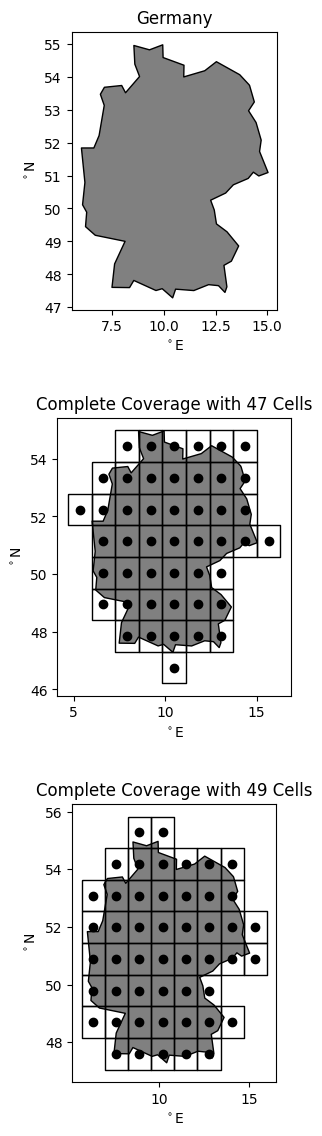

In [19]:
###############################################
# Start to create a figure with three subplots
fig, ax = plt.subplots(3,1, figsize=(5,12)) # we want to have three subplot below each other
axs = ax.flat # the subplots are called axes ("ax"). We save them in an iterable numpy array called "axs".


# First subplot: Only map of germany
germany.plot(ec='black', fc="gray", figsize=(10,10), ax=axs[0], label  = 'test') # Plot the shape of germany in the first subplot ("axs[0]")
axs[0].set_title('Germany') # Create the title for the first subplot

import numpy as np
# Second subplot: Germany covered by grid cells
# Call the function 'create_grid' defined above to create a grid of cells (polygons) to cover germany
# Note that the parameters vx_shift and hy_shift are not called. They default to zero, i.e. to no shift
gr = cg.create_grid(germany, v_n_cells=v_n_cells, h_n_cells=h_n_cells, overlap=overlap, crs=crs)
#print("gr: ", gr, type(gr))

# Compute centroids of the rectangles, in order to do so without errors, we need to project the rectangles to a flat surface preserving the area inside
# the recangles. We do so using the projection method '+proj=cea'.
gr_centroids = gr.to_crs('+proj=cea').centroid.to_crs(gr.crs)
#print("gr_ceontroids: ", gr_centroids, type(gr_centroids))

germany.plot(ec='black', fc="gray", figsize=(10,10), ax=axs[1]) # plot germany again in the background
gr.plot(fc="none", ec='black', ax=axs[1]) # also plot the grid
# create the title of the second subplot
axs[1].set_title('Complete Coverage with ' + str(np.shape(gr)[0]) + ' Cells') # "np.shape(gr)[0]" is equal to the number cells needed to cover Germany
gr_centroids.plot(fc= 'black', ec='black', ax=axs[1]) # plot centroids as well


# Third subplot: Here we visualize Germany and the complete coverage with the SHIFTED grid cells
# Calculate some arbitrary vertical shift "vx_shift" and a horizontal shift "hy_shift"
vx_shift = (germany.total_bounds[2] - germany.total_bounds[0]) / (1.3 * h_n_cells) # the parameter 1.3 is chosen arbitrarily to induce a small shift
hy_shift = (germany.total_bounds[3] - germany.total_bounds[1]) / (1.3 * v_n_cells) # the parameter 1.3 is chosen arbitrarily to induce a small shift

# call the self defined create_grid function again, now including the parameters vx_shift and hy_shift
gr_shift = cg.create_grid(germany, v_n_cells=v_n_cells, h_n_cells=h_n_cells, vx_shift = vx_shift, hy_shift= hy_shift, overlap=overlap, crs=crs)
#print("gr_shift: ", gr_shift, type(gr_shift))

# Again: Compute centroids of shifted rectangles
gr_shift_centroids = gr_shift.to_crs('+proj=cea').centroid.to_crs(gr_shift.crs)
#print("gr_ceontroids: ", gr_shift_centroids, type(gr_shift_centroids))

germany.plot(ec='black', fc="gray", figsize=(10,10), ax=axs[2]) # plot germany again in the background again
gr_shift.plot(fc="none", ec='black', ax=axs[2]) # now plot the shifted grid
# create the title for the third subplot
axs[2].set_title('Complete Coverage with ' + str(np.shape(gr_shift)[0]) + ' Cells')  # "np.shape(gr)[0]" is equal to the number cells needed to cover Germany
gr_shift_centroids.plot(fc= 'black', ec='black', ax=axs[2]) # plot the shifted centroids


## set x- and y-axis labels to °E and °N, so it becomes clear that we are looking at a coordinate system
axs[0].set_xlabel("$^\circ$E")
axs[0].set_ylabel("$^\circ$N")
axs[1].set_xlabel("$^\circ$E")
axs[1].set_ylabel("$^\circ$N")
axs[2].set_xlabel("$^\circ$E")
axs[2].set_ylabel("$^\circ$N")

plt.tight_layout(pad=3)
plt.show()

### Connecting the Centroids (Travelling Salesperson Problem)
Next, we try to trace the centroids of the two grids via a path of shortest possible length. Under the restriction that we the path should end at the same point where it started, this problem reduces to an instance of the **Travelling Salesperson Problem (TSP)**. We employ the 
[**Christophides Algorithm**](https://en.wikipedia.org/wiki/Christofides_algorithm), which delivers an approximative solution to the TSP. The solution of the Christophides Algorithm is proven to be not longer than $\frac{3}{2}OPT$, where $OPT$ is the length of the exact TSP solution (i.e. the length of the optimal path).

In [20]:
# save the coordinates of the centroids in the list "centroid_coord_list" and "centroid_shift_coord_list" respectively
centroid_coord_list = gr_centroids.get_coordinates()
centroid_coord_list = centroid_coord_list.values.tolist()
centroid_shift_coord_list = gr_shift_centroids.get_coordinates() # the same for the shifted centroids (nodes)
centroid_shift_coord_list = centroid_shift_coord_list.values.tolist()

# The python file christophides ("cr") provides a function 'build_graph', which builds a dictionary from a list of coordinated.
# The resulting dictionary contains information on the distances between all the points in the network and represents our data for a complete graph
cG = cr.build_graph(centroid_coord_list)
cG_shift = cr.build_graph(centroid_shift_coord_list) # the same for the shifted centroids (nodes)
#print("complete_graph:", cG)

# The function tsp corresponds to the Christophides Algorithm. Respectively, the outputs 'length' and 'path' are the length
# and the list of nodes traced by the Christophides solution.
length, path = cr.tsp(centroid_coord_list)
length_shift, path_shift = cr.tsp(centroid_shift_coord_list) # the same for the shifted centroids (nodes)
#print("length: ", length, " path: ", path)

# The function "path_to_subgraph" takes in a complete graph and path, and forms a subgraph that
# only contains those edges, which are traced by the path (i.e. the approximately optimal TSP solutoin of the Christophides Algorithm)
SG = cr.path_to_subgraph(cG, path)
SG_shift = cr.path_to_subgraph(cG_shift, path_shift)
print("Approximately optimal subgraph (Christophides Solution): ", "\n", SG, "\n")
print("Approximately optimal subgraph (Christophides Solution for shifted grids): ", "\n" , SG_shift, "\n")

Approximately optimal subgraph (Christophides Solution):  
 {2: {1: 1.1}, 1: {7: 1.29}, 7: {6: 1.1}, 6: {13: 1.29}, 13: {14: 1.1}, 14: {15: 1.1}, 15: {16: 1.1}, 16: {17: 1.1}, 17: {18: 1.1}, 18: {19: 1.1}, 19: {12: 1.29}, 12: {11: 1.1}, 11: {10: 1.1}, 10: {9: 1.1}, 9: {8: 1.1}, 8: {21: 3.39}, 21: {22: 1.1}, 22: {23: 1.1}, 23: {24: 1.1}, 24: {25: 1.1}, 25: {26: 1.1}, 26: {27: 1.1}, 27: {34: 1.29}, 34: {33: 1.1}, 33: {32: 1.1}, 32: {31: 1.1}, 31: {30: 1.1}, 30: {29: 1.1}, 29: {28: 1.1}, 28: {35: 1.29}, 35: {36: 1.1}, 36: {37: 1.1}, 37: {38: 1.1}, 38: {39: 1.1}, 39: {40: 1.1}, 40: {41: 1.1}, 41: {45: 1.29}, 45: {44: 1.1}, 44: {43: 1.1}, 43: {42: 1.1}, 42: {46: 1.29}, 46: {20: 6.77}, 20: {0: 7.53}, 0: {4: 1.29}, 4: {5: 1.1}, 5: {3: 2.19}, 3: {2: 1.1}} 

Approximately optimal subgraph (Christophides Solution for shifted grids):  
 {1: {0: 1.1}, 0: {6: 1.29}, 6: {5: 1.1}, 5: {12: 1.29}, 12: {13: 1.1}, 13: {14: 1.1}, 14: {15: 1.1}, 15: {16: 1.1}, 16: {17: 1.1}, 17: {18: 1.1}, 18: {19: 1.1}, 1

In [21]:
# Just some operation on the dictionary representing the subgraph (SG here). We introduce the string "weight" before each of the distance between
# nodes, to decplare to the computer, that the node distances are the edge weights in our graph
for k, d in SG.items():
    for ik in d:
        d[ik] = {'weight': np.around(d[ik],1)}

for k, d in SG_shift.items(): # the same for the shifted centroids (nodes)
    for ik in d:
        d[ik] = {'weight': np.around(d[ik],1)}
        
# transform the subgraph from format "dictionary" to format "Graph" as recognized by the graph plotting library networkx ("nx")
SG = nx.from_dict_of_dicts(SG) 
SG_shift = nx.from_dict_of_dicts(SG_shift) # the same for the shifted centroids (nodes)

# We also have to fix the positions of the nodes according to their coordinates, otherwise networkx arbitrarily shifts around the node positions
# to fit in the plot and have equal distances
pos = {}
for this in range(len(centroid_coord_list)):
            if this not in pos:
                pos[this] = {}
            pos[this] = centroid_coord_list[this]
fixed_nodes = pos.keys()

pos_shift = {} # the same for the shifted centroids (nodes)
for this in range(len(centroid_shift_coord_list)):
            if this not in pos_shift:
                pos_shift[this] = {}
            pos_shift[this] = centroid_shift_coord_list[this]
fixed_nodes_shift = pos_shift.keys()

# the dictionary pos will tell networkx exactly where to put the nodes on the graph. Their positions will not correspond to their real positions
# of the centroids of the rectangles covering Germany
pos = nx.spring_layout(SG, pos=pos, fixed = fixed_nodes)
pos_shift = nx.spring_layout(SG_shift, pos=pos_shift, fixed = fixed_nodes_shift) # the same for the shifted centroids (nodes)

### Creating Figures Again

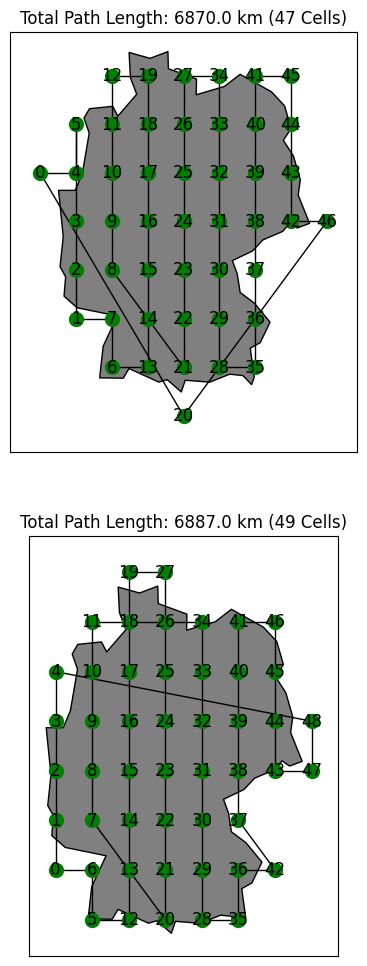

In [22]:
fig, ax = plt.subplots(2,1, figsize=(5,12)) # this time we want to have two subplots above each other
axs = ax.flat # the subplots are called axes ("ax"). We save them in an iterable numpy array called "axs".

# First Subplot: Approximative TSP Solution along the 47 centroids of the non-shifted grid
axs[0].set_title('Total Path Length: ' + str(np.around(length*100,0)) + " km (" + str(np.shape(gr)[0]) + " Cells)") # create the title of the subplot
germany.plot(ec='black', fc="gray", ax=axs[0])
nx.draw_networkx(SG, pos, node_color = 'green', node_size = 100, ax=axs[0])
#print("optimal Subgraph (TSP Solution): ", SG)

# Second Subplot: Approximative TSP Solution along the 49 centroids of the SHIFTED grid
axs[1].set_title('Total Path Length: ' + str(np.around(length_shift*100,0)) + " km (" + str(np.shape(gr_shift)[0]) + " Cells)") # create the title of the subplot
germany.plot(ec='black', fc="gray", ax=axs[1])
nx.draw_networkx(SG_shift, pos_shift, node_color = 'green', node_size = 100, ax=axs[1])
#print("shifted optimal Subgraph (TSP Solution) : ", SG_shift)

plt.show()